# Updated Stackplot Script using Velocity Windowed Maximum Amplitude Selection
Contains several different versions of codes which make single line moveout plots from the `BASIN XCORR h5` files. In-line notation and markdown cells might be helpful for deciding what is useful.

In [2]:
# Packages - set GR as plotting backend 
#include("/Users/julianschmitt/Documents/Schoolwork/Seismology/SeisCore.jl/src/SeisCore.jl")
using Pkg, SeisCore, SeisIO, SeisNoise, Plots, Dates, CSV, DataFrames, Distributed, JLD2, Statistics, PyCall, Glob, StructArrays, ColorSchemes, Plots.PlotUtils, HDF5, AbstractFFTs
ENV["GR"] = ""
Pkg.build("GR")
loadcolorscheme(:cm_maxamp,ColorSchemes.gist_heat.colors[end-50:-1:1], "maxamp color", "for waveform plot");

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/Users/julianschmitt/.julia/packages/Plots/SjqWU/src/backends/hdf5.jl", 162, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000100c8311f, Ptr{Nothing} @0x0000000100d1ceb3, Ptr{Nothing} @0x0000000100d1dfab, Ptr{Nothing} @0x0000000100d1c8df, Ptr{Nothing} @0x0000000100d1cbbc, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x0000000100d361ce, Ptr{Nothing} @0x0000000100d351b1, Ptr{Nothing} @0x0000000100d359d1, Ptr{Nothing} @0x0000000100d360d6, Ptr{Nothing} @0x0000000100d0eb6d, Ptr{Nothing} @0x0000000100d3727c, Ptr{Nothing} @0x0000000105a47d4f, Ptr{Nothing} @0x000000013a94a99e, Ptr{Nothing} @0x0000000100d1dfcf, Ptr{Nothing} @0x0000000100d1c8df, Ptr{Nothing} @0x0000000100d1cbbc, Base.InterpreterIP in top-level CodeInfo for Plots at statement 10, Ptr{Nothing} @0x0000000100d361ce, Ptr{Nothing} @0x0000000100d37074, Ptr{Nothing} @0x

In [3]:
# metaparams for plots
n_derivatives = 2
n_deriv_names = ["Raw","PGD","PDV"]
#plot_sorttype = "Latitude" # other options include "Longitude" and (soon) "Distance" (in progress...) 
years = [2017, 2018, 2019]
components = ["ZZ"]#["EE","EN","EZ","NE", "NN", "NZ","ZE","ZN", "ZZ"]
source_stations = ["SVD"]#["CHN","CJM","DEV","IPT","LPC","SNO","SVD","TA2"]
rootdir = "/Users/julianschmitt/Desktop/SeisPlots2" # chose root directory for plots
lw, scale, frequency_plots = 0.5, 3, [[0.1,0.2],[0.15, 0.25],[0.2,0.3],[0.1,0.35]]
locations = DataFrame(CSV.File("/Users/julianschmitt/Documents/Schoolwork/Seismology/C4-Project.jl/docs/modified_nodal.csv"));

In [4]:
function plot_by_distance(corrs::Array{CorrData,1}, freqs::Array{Array{Float64,1},1}, 
                            attr::Array{String,1}=["","","",""], src_geo::Any=nothing)
    source = attr[1]
    source_geo = src_geo
    if src_geo == nothing
        source_geo = LLE_geo(attr[1], locations)
    end
    sort_method, p = [], []
    if plot_sorttype == "Latitude"
        sort_method = sort([corr.loc.lat for corr in corrs])
        p = sortperm([corr.loc.lat for corr in corrs]) # sort based on latitude 
    elseif plot_sorttype == "Longitude"
        sort_method = sort([corr.loc.lon for corr in corrs])
        p = sortperm([corr.loc.lon for corr in corrs]) # sort based on longitude
    else # sort by distance 
        println("Sorting by distance")
        plot_sorttype == "Distance"
        sort_method = sort([get_dist(source_geo, corr.loc) for corr in corrs])
        p = sortperm([get_dist(source_geo, corr.loc) for corr in corrs])
        #println("Not currently a supported stacktype")
    end


    lmin, lmax = minimum(sort_method), maximum(sort_method)
    new_corrs, n_corrs = corrs[p], length(corrs)
    y_labels = (round.(collect(range(0, 5*n_corrs, length=10)),digits=3),round.(collect(range(lmin, lmax, length=10)),digits=3))
    for freq_pair in freqs
        NS_plot = plot(xlims = (-150,150), ylims = (-5,n_corrs*5+15), 
                    yticks=y_labels,xlabel = "Time (s)", ylabel = "Station Nodes by $plot_sorttype (km)",  
                    xtickfontsize=5,ytickfontsize=5,fontsize=5, xguidefontsize = 10, yguidefontsize = 10,
                    legendfontsize = 10, title="$(attr[3]) $(attr[2]) from $(attr[1]): $(freq_pair[1]) to $(freq_pair[2])",
                    titlefontsize= 10)
        # bandpass correlations 
        corrs_processed, max_amp = [], []
        ys, maxloc = [], []
        for corr in new_corrs
            # bandpass, scale, shift, and add to plot
            dist = get_dist(source_geo, corr.loc)
            processed = bandpass(corr, freq_pair[1], freq_pair[2]).corr ./scale
            # get index for color scaling 
            #println(dist)
            middle = convert(Int64, round(length(processed)/2))
            range = [convert(Int64, round(middle-(dist/5)*corr.fs)), convert(Int64, round(middle-(dist/1.5)*corr.fs))]
            #println(range, "  ", length(processed))
            anticausal = Int(round(6000-20*dist/1.5)):Int(round(6000-20*dist/5))
            fmax = getindex(findmax(processed[anticausal])[2],1)+anticausal[1]
#             println(fmax)
#             println(fmax, findmax(processed))
            shift = ((dist -lmin)/(lmax-lmin)*n_corrs*5)
            push!(maxloc, fmax)
            push!(ys, shift)
            push!(max_amp, findmax(processed[anticausal]))
            push!(corrs_processed, processed .+ shift)
        end

        # plotting
        T = collect(-300.:1/new_corrs[1].fs:300.)
        #amplitudes = [amp[1] for amp in max_amp]
#         println(typeof(max_amp))
#         println(max_amp)
#         println(typeof(getindex.(max_amp,1)))
#         println(getindex.(max_amp,1))
        plot!(NS_plot, T, corrs_processed, color=:cm_maxamp, colorbar_title="Normalized Maximum Amplitude", 
                line_z=getindex.(max_amp,1)', fmt = :png, linewidth = 0.5, reuse = false, legend = false)    
        plot!(size=(350,400),dpi=500)
        
        # add dots where max_amp is chosen 
        #dot_locations = [amp[2] for amp in max_amp]
        #y = 5 .* collect(0:length(max_amp))
        #scatter!(getindex.(getindex.(max_amp,2),1) ./20, y, color="black", markersize=2)
        mloc = [T[ind] for ind in maxloc]
        scatter!(mloc, ys, color="black", markersize=1.2)
        filepath = joinpath(rootdir,
            "final_heatplots/PGV_$(attr[4])/$(attr[1])/$(attr[3])_from_$(attr[1])_$(attr[2])_$(freq_pair[1])to$(freq_pair[2]).png")
        # ensure filepath is valid 
        DIR = dirname(filepath)
        if !isdir(DIR)
            mkpath(DIR)
        end
        png(NS_plot,filepath)
    end
end

plot_by_distance (generic function with 3 methods)

In [5]:
cd("/")
cd("/Volumes/T7/seis_data")
files = glob("final_stack/*/*");

In [15]:
filter!(x -> occursin("SVD", x), files)

3-element Array{String,1}:
 "nodestack_new/2017/CI.SVD_2017.h5"
 "nodestack_new/2018/CI.SVD_2018.h5"
 "nodestack_new/2019/CI.SVD_2019.h5"

## Stackplot Script for BASIN Data

In [27]:
plot_sorttype = "Distance"
scales = [0.000000000002, 0.0000000000002, 0.00000000002 ] # inverse scale - for correlations 
for f in files
    year = split(f,"/")[end-1]
    try  
        file = h5open(f,"r")
        for comp in components
            for (ind, sktype) in enumerate(["linear"])#,"pws","robust"])
                scale = scales[ind] # adjust scale based on stacktype
                for filt in ["NO.B1"]#, "NO.B2","NO.B3", "NO.B4","NO.B5","NO.B6","NO.G1","NO.G2","NO.G3","NO.G4"]
                    source, stacktype, component, filter = convert(String, split(f, ".")[end-1][1:3]), sktype, comp, filt
                    fcorrs = get_corrs2(file, stacktype, component, filter)
                    if length(fcorrs) > 1
                        println("Plotting $filt $comp $sktype for $source in $year")
                        attributes = [source,component,stacktype]
                        plot_by_distance(fcorrs, frequency_plots,attributes)
                    end
                end
            end
        end
    catch e
        println(e)
    end
end

HDF5 data file: /Users/julianschmitt/Downloads/CORR_20HZ_2004_January_AZ.BZN.h5linearZZNO.B1
CorrData[]


In [26]:
close(f)
f = h5open(files[1], "r")
A = read(f)
A["CI.MPI"]

Dict{String,Any} with 10 entries:
  "EZ"   => Dict{String,Any}("linear"=>Float32[0.000905757, 0.000233388, 0.0004…
  "NZ"   => Dict{String,Any}("linear"=>Float32[-0.000227304, -0.000508794, -0.0…
  "meta" => Dict{String,Any}("lat"=>34.8126,"azi"=>303.358,"baz"=>121.967,"dist…
  "ZE"   => Dict{String,Any}("linear"=>Float32[-0.000235651, -9.40722f-5, -0.00…
  "EN"   => Dict{String,Any}("linear"=>Float32[0.000119186, -2.72288f-5, -0.000…
  "ZN"   => Dict{String,Any}("linear"=>Float32[-0.000469991, -0.000425991, 8.30…
  "NN"   => Dict{String,Any}("linear"=>Float32[0.000891385, -2.05773f-5, 2.9182…
  "EE"   => Dict{String,Any}("linear"=>Float32[-0.000142263, -0.000251057, -8.7…
  "NE"   => Dict{String,Any}("linear"=>Float32[-0.00035071, -0.000866775, 0.000…
  "ZZ"   => Dict{String,Any}("linear"=>Float32[0.000377343, -0.000263691, -0.00…

In [4]:
function get_corrs2(file::HDF5File, stacktype::String="linear",
    component::String="ZZ", filter::String="")
    filtered = [name for name in names(file) if occursin(filter, name)] 
    corrs = [create_corr(file, station, stacktype, component) for station in filtered]
    corrs = [corr for corr in corrs if !isnothing(corr)] # strip nothings - catches meta file etc which errors
    if n_derivatives !=0
        for i in 1:n_derivatives
            corrs = [fftderivative(corr) for corr in corrs]
        end
    end
    return corrs
end 

get_corrs2 (generic function with 4 methods)

## Moveout Plot Script for C4 Data

In [69]:
function plot_by_distance(corrs::Array{CorrData,1}, freqs::Array{Array{Float64,1},1}, 
                            attr::Array{String,1}=["","","",""], src_geo::Any=nothing, fs::Float64=20.)
    source = attr[1]
#     source_geo = src_geo
#     if src_geo == nothing
#         source_geo = LLE_geo(attr[1], locations)
#     end
    sort_method, p = [], []
    if plot_sorttype == "Latitude"
        sort_method = sort([corr.loc.lat for corr in corrs])
        p = sortperm([corr.loc.lat for corr in corrs]) # sort based on latitude 
    elseif plot_sorttype == "Longitude"
        sort_method = sort([corr.loc.lon for corr in corrs])
        p = sortperm([corr.loc.lon for corr in corrs]) # sort based on longitude
    else # sort by distance 
        println("Sorting by distance")
        plot_sorttype == "Distance"
        sort_method = sort([corr.dist for corr in corrs])#sort([get_dist(source_geo, corr.loc) for corr in corrs])
        p = sortperm([corr.dist for corr in corrs])#[get_dist(source_geo, corr.loc) for corr in corrs])
        #println("Not currently a supported stacktype")
    end


    lmin, lmax = minimum(sort_method), maximum(sort_method)
    new_corrs, n_corrs = corrs[p], length(corrs)
    y_labels = (round.(collect(range(0, 5*n_corrs, length=10)),digits=3),round.(collect(range(lmin, lmax, length=10)),digits=3))
    for freq_pair in freqs
        NS_plot = plot(xlims = (-60,60), ylims = (-5,n_corrs*5+15), 
                    yticks=y_labels,xlabel = "Time (s)", ylabel = "Station Nodes by $plot_sorttype (km)",  
                    xtickfontsize=5,ytickfontsize=5,fontsize=5, xguidefontsize = 10, yguidefontsize = 10,
                    legendfontsize = 10, title="$(attr[3]) $(attr[2]) from $(attr[1]): $(freq_pair[1]) to $(freq_pair[2])",
                    titlefontsize= 10)
        # bandpass correlations 
        corrs_processed = []
        max_amp = []
        ys, maxloc = [], []
        for (ind, corr) in enumerate(new_corrs)
#             try
                # bandpass, scale, shift, and add to plot
                dist = corr.dist #ind*5#get_dist(source_geo, corr.loc)
                #png(plot(corr.corr), joinpath(rootdir, "test_1HZ_pre_$(corr.name).png"))
                
                #processed = bandpass(corr.corr, freq_pair[1], freq_pair[2], 20.)
                processed = taper(bandpass(corr, freq_pair[1], freq_pair[2])).corr
                #png(plot(processed), joinpath(rootdir, "test_1HZ_post_$(corr.name).png"))
                #println(length(processed), "  " , dist)
                # get index for color scaling 
                println(dist, "  ", corr.name)
                middle = convert(Int64, round(length(processed)/2))
                range = [convert(Int64, floor(middle-(dist/5)*corr.fs)), convert(Int64, ceil(middle-(dist/1.5)*corr.fs))]
                #println(middle, "  ", length(processed))

                anticausal = Int(round(middle-fs*dist/1.5)):Int(round(middle-fs*dist/5))
                #println(anticausal)
                fmax = getindex(findmax(processed[anticausal])[2],1)+anticausal[1]
                #println(fmax)
    #             println(fmax)
    #             println(fmax, findmax(processed))
                shift = ind *5#((dist -lmin)/(lmax-lmin)*n_corrs*5)
                push!(maxloc, fmax)
                push!(ys, shift)
                push!(max_amp, findmax(processed[anticausal]))
                #println(processed)
                push!(corrs_processed, processed .*10e10 .+ shift)
#                 catch e
#                 println(e)
#                 break
#             end
        end
        #println(corrs_processed)
        # plotting
        T = collect(-300.:1/fs:300.)
        #println(T)
        #amplitudes = [amp[1] for amp in max_amp]
#         println(typeof(max_amp))
#         println(max_amp)
#         println(typeof(getindex.(max_amp,1)))
#         println(getindex.(max_amp,1))
        plot!(NS_plot, T, corrs_processed, color=:cm_maxamp, colorbar_title="Normalized Maximum Amplitude", 
                line_z=getindex.(max_amp,1)', fmt = :png, linewidth = 0.5, reuse = false, legend = false)    
        plot!(size=(350,400),dpi=500)
        
        # add dots where max_amp is chosen 
        #dot_locations = [amp[2] for amp in max_amp]
        #y = 5 .* collect(0:length(max_amp))
        #scatter!(getindex.(getindex.(max_amp,2),1) ./20, y, color="black", markersize=2)
        mloc = [T[ind] for ind in maxloc]
        #scatter!(mloc, ys, color="black", markersize=1.2)
        filepath = joinpath(rootdir,
            "nodestack_windowed/PGV_$(attr[4])/$(attr[1])/$(attr[3])_$(attr[5])_$(attr[1])_$(attr[2])_$(freq_pair[1])to$(freq_pair[2]).png")
        # ensure filepath is valid 
        DIR = dirname(filepath)
        if !isdir(DIR)
            mkpath(DIR)
        end
        png(NS_plot,filepath)
    end
end

plot_by_distance (generic function with 4 methods)

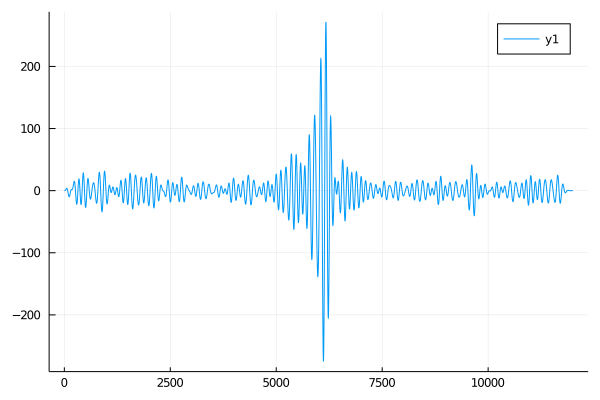

In [45]:
plot(taper(bandpass(corrs[1], 0.1, 0.2)).corr .* 10e12)

In [47]:
plot_sorttype="Distance"
comp = "ZZ"
tag = "SMOOTH_50"
allf = glob("*.jld2", "/Volumes/T7/seis_data/test/CORR_$tag/CI.PASC/$comp/")
corrs = map(f -> load_corr(f, comp), allf)
corrs = map(c -> fftderivative(fftderivative(c)), corrs)
plot_by_distance(corrs, [[0.5,1.],[0.1,0.35]],["CI.PSAC",comp,"20HZ","single_corr", tag], 
                    GeoLoc(lat = 34.1065, lon=-117.098))

Sorting by distance
16.05105193980251  CI.PASC.00.HHZ.NO.G1002.--.EHZ
16.14625165833355  CI.PASC.00.HHZ.NO.G1003.--.EHZ
16.174526942936925  CI.PASC.00.HHZ.NO.G1004.--.EHZ
16.1987048938422  CI.PASC.00.HHZ.NO.G1005.--.EHZ
16.20487493011879  CI.PASC.00.HHZ.NO.G1006.--.EHZ
16.221483684290956  CI.PASC.00.HHZ.NO.G1007.--.EHZ
16.331762725719823  CI.PASC.00.HHZ.NO.G1010.--.EHZ
16.36032597862476  CI.PASC.00.HHZ.NO.G1008.--.EHZ
16.40883941278451  CI.PASC.00.HHZ.NO.G1009.--.EHZ
16.46859269376541  CI.PASC.00.HHZ.NO.G1012.--.EHZ
16.48280958079206  CI.PASC.00.HHZ.NO.G1011.--.EHZ
16.65264559136419  CI.PASC.00.HHZ.NO.G1013.--.EHZ
16.6786100972661  CI.PASC.00.HHZ.NO.G1014.--.EHZ
16.745549293672557  CI.PASC.00.HHZ.NO.G1015.--.EHZ
16.808381699262263  CI.PASC.00.HHZ.NO.G1016.--.EHZ
16.850545280705628  CI.PASC.00.HHZ.NO.G1017.--.EHZ
16.92845672156747  CI.PASC.00.HHZ.NO.G1018.--.EHZ
16.977955853892507  CI.PASC.00.HHZ.NO.G1019.--.EHZ
17.081232305959063  CI.PASC.00.HHZ.NO.G1021.--.EHZ
17.19122852578347  CI.PA

In [154]:
@eval @everywhere locations = DataFrame(CSV.File("/Users/julianschmitt/Downloads/full_socal.csv"));
using Statistics
function compare_maxamps(smoothed::String, unsmoothed::String)
    # get files and load corrs
    smoothedf = glob("*.jld2", "/Volumes/T7/seis_data/test/$smoothed/CI.CHN/ZZ/")
    unsmoothedf = glob("*.jld2", "/Volumes/T7/seis_data/test/$unsmoothed/CI.CHN/ZZ/")
    
    corrs_sm = map(f -> load_corr(f, "ZZ"), smoothedf)
    corrs_un = map(f -> load_corr(f, "ZZ"), unsmoothedf)
    
    corrs_sm = map(corr -> fftderivative(fftderivative(corr)), corrs_sm)
    corrs_un = map(corr -> fftderivative(fftderivative(corr)), corrs_un)
    
#     plot_by_distance(corrs_sm, [[0.5,1.],[0.1,0.35]],["CI.CHN","ZZ","20HZ","single_corr", "smoothed"])
#     plot_by_distance(corrs_un, [[0.5,1.],[0.1,0.35]],["CI.CHN","ZZ","20HZ","single_corr", "not_smoothed"])
    
    sm_deriv = [maximum(abs.(corr.corr)) for corr in corrs_sm]
    un_deriv = [maximum(abs.(corr.corr)) for corr in corrs_un]
    println("Smoothed median no mm", mean(sm_deriv))
    println("Smoothed median with mm", mean(un_deriv))
    
#     plot(sm_deriv, label = "Smoothed 50 pt 2x deriv", title="Amplitude (Velocity) comparison: Smoothed vs Unsmoothed", dpi=200)
#     plot!(un_deriv, label = "Unsmoothed 2x deriv")
#     png("/Users/julianschmitt/Downloads/CHN_ZZ_B4_SMOOTH_VS_UNSMOOTH_VEL_NO_MM.png")
end
compare_maxamps("CHN_G1_SMOOTHED_NO_MM", "CHN_G1_SMOOTHED")

Smoothed median no mm1.0201985846372391e-7
Smoothed median with mm1.0201985846372391e-7


In [62]:
allf = glob("*.jld2", "/Volumes/T7/seis_data/test/CORR_SMOOTH_50/CI.PASC/ZZ/")
corrs = map(f -> load_corr(f, "ZZ"), allf)
corrs = map(corr -> fftderivative(fftderivative(corr)), corrs)
smoothed_deriv = [maximum(abs.(corr.corr)) for corr in corrs]

30-element Array{Float64,1}:
 1.0135834067602888e-7
 9.897613445503073e-8
 1.1284405253977841e-7
 9.470783839651206e-8
 1.1294466901383901e-7
 1.0390249746642128e-7
 9.858926953937461e-8
 1.0045186035497216e-7
 9.571500180171445e-8
 1.092012080978289e-7
 1.0420878384736547e-7
 1.1520246613978183e-7
 1.0910498812075215e-7
 ⋮
 1.060491070516835e-7
 1.1635158944102993e-7
 8.859656303610154e-8
 9.010628857561901e-8
 1.0603477250272949e-7
 9.540898850482726e-8
 1.0247298094553614e-7
 9.196319614924834e-8
 1.0129315920903947e-7
 1.1722619904265266e-7
 9.981293336560298e-8
 9.319338617850524e-8

In [106]:
corrs = map(f -> load_corr(f, "ZZ"), allf);


In [111]:
corrs[1].corr ==corrs[2].corr

false

In [120]:
c1 = corrs[1]
c2 = deepcopy(c1)
c2.corr = corrs[2].corr
c1.corr == corrs[1].corr

true

In [162]:
#ar = [c.corr for c in corrs]

A = AbstractArray{}


LoadError: [91mMethodError: no method matching setindex!(::Type{AbstractArray}, ::Array{Float32,2}, ::Int64)[39m

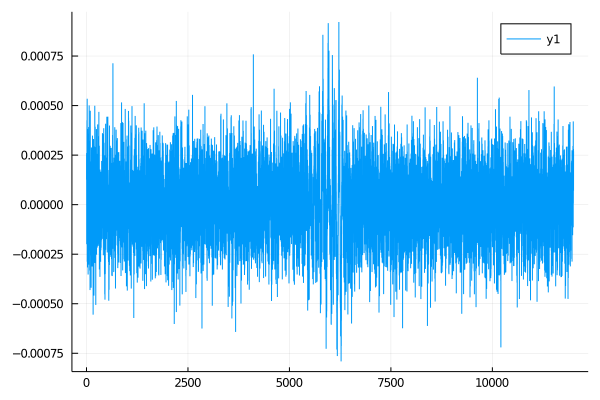

In [159]:
bandpass(plot(mean([c.corr for c in corrs])), 

In [148]:
c= sum([corrs[1],corrs[2]])
#c.corr == (c1.corr + c2.corr)
c.corr

12001×1 Array{Float32,2}:
  0.0011026117
 -1.5600532f-5
 -0.0010217165
  0.00063945545
 -0.00056357845
 -0.00025559997
  0.00091366004
 -0.00011631987
 -0.0006247905
  0.00042127885
  0.0019094687
 -6.2901913f-6
  0.00013405735
  ⋮
  0.0009545142
  0.0019305275
  0.0010659973
  0.00080278463
  0.0006712203
 -0.00057831185
  0.00042506028
  0.0009375952
  0.0017207573
  0.00019034074
  0.00019055039
  0.0002497968

In [146]:
SeisNoise.stack(c, allstack=true, stacktype=mean).corr

12001×1 Array{Float32,2}:
 -0.000107715896
  0.0004752194
  0.00028143713
 -0.00029622103
 -0.00037046632
 -0.00090800563
  0.000600294
  0.00019376451
 -0.00074376736
  0.00037339033
  0.0011267216
 -0.00081054866
  3.2965072f-5
  ⋮
  0.0006909587
  0.00013814529
  0.00057746546
  0.00080328924
 -4.537002f-5
 -0.00024010787
  0.00049027544
  0.00033695472
  0.0014853291
  6.703156f-5
  0.0011825477
  0.00021309292

In [66]:

plot(smoothed_deriv, label = "Smoothed 50 pt 2x deriv", title="Amplitude (Velocity) comparison: Smoothed vs Unsmoothed", dpi=200)
plot!(unsmoothed_deriv, label = "Unsmoothed 2x deriv")
png("/Users/julianschmitt/Downloads/SMOOTH_VS_UNSMOOTH_WITH_DERIV.png")

In [145]:
function plot_by_distance(corrs::Array{CorrData,1}, freqs::Array{Array{Float64,1},1}, 
                            attr::Array{String,1}=["","","",""], src_geo::Any=nothing)
    n_corrs = length(corrs)
    for freq_pair in freqs
        NS_plot = plot(xlims = (-150,150), ylims = (-5,n_corrs*5+15), 
                    xlabel = "Time (s)", ylabel = "Station Nodes by $plot_sorttype (km)",  
                    xtickfontsize=5,ytickfontsize=5,fontsize=5, xguidefontsize = 10, yguidefontsize = 10,
                    legendfontsize = 10, title="$(attr[3]) $(attr[2]) from $(attr[1]): $(freq_pair[1]) to $(freq_pair[2])",
                    titlefontsize= 10)
        # bandpass correlations 
        corrs_processed = []
        for (ind, corr) in enumerate(corrs)
            # bandpass, scale, shift, and add to plot
            processed = bandpass(corr, freq_pair[1], freq_pair[2]).corr ./scale
            push!(corrs_processed, processed .+ ind*5)
        end

        # plotting
        T = collect(-300.:1/corrs[1].fs:300.)
        plot!(NS_plot, T, corrs_processed, color=:cm_maxamp, colorbar_title="Normalized Maximum Amplitude", 
                line_z=getindex.(max_amp,1)', fmt = :png, linewidth = 0.5, reuse = false, legend = false)    
        plot!(size=(350,400),dpi=500)
        filepath = joinpath(rootdir,
            "nodestack_windowed/PGV_$(attr[4])/$(attr[1])/$(attr[3])_from_$(attr[1])_$(attr[2])_$(freq_pair[1])to$(freq_pair[2]).png")
        # ensure filepath is valid 
        DIR = dirname(filepath)
        if !isdir(DIR)
            mkpath(DIR)
        end
        png(NS_plot,filepath)
    end
end
plot_by_distance(corrs, [[0.1,0.35],[0.15,0.25]],["CI.SVD","ZZ","20HZ","single_corr"], 
                    GeoLoc(lat = 34.1065, lon=-117.098))

LoadError: [91mUndefVarError: max_amp not defined[39m

In [140]:
filter(x -> x.station == "SVD", locations)

,network,station,latitude,longitude,elevation
,String,String,Float64,Float64,Int64
1,CI,SVD,34.1065,-117.098,605
2,CI,SVD,34.1065,-117.098,0


In [133]:
files = ["/Users/julianschmitt/Downloads/CORR_1HZ_2004_January_AZ.BZN.h5"]
#scales = [0.000000000002, 0.0000000000002, 0.00000000002 ] # inverse scale - for correlations 
scales = [0.0000000002, 0.00000000002, 0.000000002 ]
plot_sorttype = "Distance"
for f in files
    year = split(f,"_")[end-2]
    try  
        file = h5open(f,"r")
        src_geo = GeoLoc(lat = A["meta"]["lat"], lon = A["meta"]["lon"], el=A["meta"]["el"])
        for comp in components
            for (ind, sktype) in enumerate(["linear","pws","robust"])
                scale = scales[ind] # adjust scale based on stacktype
                for filt in [""]#, "NO.B2","NO.B3", "NO.B4","NO.B5","NO.B6","NO.G1","NO.G2","NO.G3","NO.G4"]
                    source, stacktype, component, filter = "AZ.BZN", sktype, comp, filt
                    fcorrs = get_corrs2(file, stacktype, component, filter)
                    if length(fcorrs) > 1
                        println("Plotting $filt $comp $sktype for $source in $year")
                        attributes = [source,component,"1HZ",stacktype]
                        plot_by_distance(fcorrs, frequency_plots,attributes, src_geo, 1.)
                    end
                end
            end
        end
    catch e
        println(e)
    end
end

Plotting  ZZ linear for AZ.BZN in 2004


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 596 in H5O__open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 551 in H5O_open_name(): object not found
    major: Object header
    minor: Object not found
  #003: H5Gloc.c line 422 in H5G_loc_find(): can't find object
    major: Symbol table
    minor: Object not found
  #004: H5Gtraverse.c line 851 in H5G_traverse(): internal path traversal failed
    major: Symbol table
    minor: Object not found
  #005: H5Gtraverse.c line 627 in H5G__traverse_real(): traversal operator failed
    major: Symbol table
    minor: Callback failed
  #006: H5Gloc.c line 378 in H5G__loc_find_cb(): object 'ZZ' doesn't exist
    major: Symbol table
    minor: Object not found


Sorting by distance
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
Plotting  ZZ pws for AZ.BZN in 2004
Sorting by distance
0.0  CI.AGA


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 596 in H5O__open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 551 in H5O_open_name(): object not found
    major: Object header
    minor: Object not found
  #003: H5Gloc.c line 422 in H5G_loc_find(): can't find object
    major: Symbol table
    minor: Object not found
  #004: H5Gtraverse.c line 851 in H5G_traverse(): internal path traversal failed
    major: Symbol table
    minor: Object not found
  #005: H5Gtraverse.c line 627 in H5G__traverse_real(): traversal operator failed
    major: Symbol table
    minor: Callback failed
  #006: H5Gloc.c line 378 in H5G__loc_find_cb(): object 'ZZ' doesn't exist
    major: Symbol table
    minor: Object not found


0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
Plotting  ZZ robust for AZ.BZN in 2004
Sorting by distance
0.0  CI.AGA


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 596 in H5O__open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 551 in H5O_open_name(): object not found
    major: Object header
    minor: Object not found
  #003: H5Gloc.c line 422 in H5G_loc_find(): can't find object
    major: Symbol table
    minor: Object not found
  #004: H5Gtraverse.c line 851 in H5G_traverse(): internal path traversal failed
    major: Symbol table
    minor: Object not found
  #005: H5Gtraverse.c line 627 in H5G__traverse_real(): traversal operator failed
    major: Symbol table
    minor: Callback failed
  #006: H5Gloc.c line 378 in H5G__loc_find_cb(): object 'ZZ' doesn't exist
    major: Symbol table
    minor: Object not found


0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC
0.0  CI.AGA
0.0  CI.BCC


In [126]:
f = h5open("/Users/julianschmitt/Downloads/CORR_1HZ_2004_January_AZ.BZN.h5")
A = read(f)
tcorr = A["CI.BCC"]["ZZ"]["linear"]


601-element Array{Float32,1}:
  0.00071436696
 -0.0012756719
  5.2429852f-5
  0.0010035988
 -0.0012268879
 -0.0030777475
  0.0013146026
 -0.0008070512
  0.00040475285
  0.000583506
  0.0008030937
  0.0021065301
 -0.00037917477
  ⋮
 -0.00058367604
 -0.002664519
 -0.0012866126
  0.0009057753
  0.0008972427
  0.0036219012
 -0.00060748437
 -0.0022364384
 -0.002356793
  0.001474002
 -0.001702896
  0.00013379124

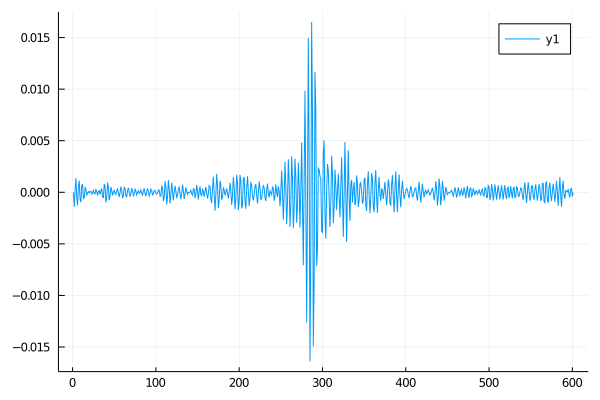

In [127]:
# c = CorrData()
# c.corr = tcorr
plot(bandpass(tcorr, 0.2, 0.3, 1.0))

In [100]:
for elt in filter(x -> x != "meta", keys(A))
    c = CorrData()
    c = A[elt]["ZZ"]["linear"]
    d = round(A[elt]["meta"]["dist"], digits = 2)
    fpath = "/Users/julianschmitt/Desktop/SeisPlots2/1HZ_test/$elt.png"
    if !isdir(dirname(fpath)); mkpath(dirname(fpath)); end
    png(plot(c, title = "$elt ZZ Raw 1 Hz Correlation at $d km"), fpath)
end

In [87]:
close(f)